In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import copy
import logging

In [2]:
class SymmetrySwitchNet(nn.Module):
    # Modified NeuralNet to learn eigenvalue (similar to an inverse problem) and adapted forward function to inherently learn symmetry or antisymmetry solutions. Optimal weight initialization for Sin activation not clear
    def __init__(self, activation,domain_extrema, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed,symmetry=False):
        super(SymmetrySwitchNet, self).__init__()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension    # can extend to approach to higher dimensions
        self.neurons = neurons
        self.n_hidden_layers = n_hidden_layers
        self.activation = activation
        self.regularization_param = regularization_param
        self.regularization_exp = regularization_exp
        self.retrain_seed = retrain_seed

        self.activation = activation
        self.domain_extrema = domain_extrema

        self.ev_in = nn.Linear(1,1)     # eigenvalue transformation

        self.symmetry_switch = symmetry

        self.symmetry_neuron = nn.Linear(1,1)

        self.input_layer = nn.Linear(self.input_dimension ,self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.res_layer = nn.Linear(self.neurons+1, self.neurons)    # They feed in eigenvalues right before output layer
        self.output = nn.Linear(self.neurons, 1)

    def parametric_conversion(self, input_pts, NN_output):
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        L = xR- xL

        fb = 0.0    # offset if needed
        g = 1*torch.cos(np.pi/L  * input_pts)   #preserves symmetry

        return fb + g*NN_output


    def forward(self, input_pts):
        eigenvalue = self.ev_in(torch.ones_like(input_pts))

        switch_val = nn.Sigmoid()(self.symmetry_neuron(torch.ones(1)))
        switch = (switch_val >=0.5) or self.symmetry_switch            # if symmetry True, always learn symmetric function

        x_neg = self.input_layer(-1*input_pts)  #negated input for symmetry transformation
        x = self.input_layer(input_pts)

        x_neg = self.activation(x_neg)
        x = self.activation(x)

        for k, l in enumerate(self.hidden_layers):
            x_neg = self.activation(l(x_neg))
            x = self.activation(l(x))

        x_neg_out= self.activation(self.output(x_neg))
        x_out= self.activation(self.output(x))

        if switch:
            out = x_out + x_neg_out
        else:
            out = x_out - x_neg_out

        out = self.parametric_conversion(input_pts,out)

        return out, eigenvalue


class ev_pinn(nn.Module):

    def __init__(self, neurons, n_hidden, xL, xR, grid_resol, batchsize, retrain_seed, sigma):
        super(ev_pinn, self).__init__()

        self.xL = xL
        self.xR = xR
        self.domain_extrema = torch.tensor([xL, xR],dtype=torch.float32)
        self.activation=  nn.Tanh() #sin_wrapper()

        self.eigenf_list = []   # should contain all the found eigenfunctions in a list
        self.eigen_vals = []

        self.symmetry= True    #tells that first eigenfunction needs to be symmetric

        self.neurons = neurons
        self.n_hidden = n_hidden


        self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                              n_hidden_layers=self.n_hidden,
                                              neurons=self.neurons,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42,
                                              symmetry=self.symmetry)

        self.grid_resol = grid_resol

        self.training_pts = self.add_points()


    def add_points(self):
        input_pts = torch.linspace(self.domain_extrema[0], self.domain_extrema[1], self.grid_resol)
        return input_pts.reshape(-1,1)

    def potential_sw(self, input_pts):

        l = a/6
        V0 = 20
        center = 0.0

        V_np = V0*(np.heaviside(-(input_pts.detach().numpy() - center + l), 0.5) + np.heaviside(input_pts.detach().numpy() - center - l, 0.5))

        return torch.from_numpy(V_np)

    def compute_pde_loss(self, input_pts):
        input_pts.requires_grad = True
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]

        f, E = self.solution(input_pts)
        grad_f_x = torch.autograd.grad(f.sum(), input_pts, create_graph=True)[0]
        grad_f_xx = torch.autograd.grad(grad_f_x.sum(), input_pts, create_graph=True)[0]

        V = self.potential_sw(input_pts)

        pde_residual = grad_f_xx/2 +  (E - V) *f
        pde_loss = torch.mean(pde_residual**2)

        return pde_loss


    def OrthoNormLoss(self, input_pts):
        f, E = self.solution(input_pts)
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        res= 0
        for NN in self.eigenf_list:
            res += ((torch.dot(NN(input_pts)[0].squeeze(), f.squeeze()))).pow(2)
        res += (torch.dot(f.squeeze(),f.squeeze()) - self.grid_resol/(xR - xL)).pow(2)

        return res

    def compute_loss(self, input_pts, verbose=True):
        input_pts.requires_grad = True
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        f, E = self.solution(input_pts)

        pde_loss = self.compute_pde_loss(input_pts)
        orth_norm_loss = self.OrthoNormLoss(input_pts)

        loss = torch.log10( 2*pde_loss + orth_norm_loss)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(pde_loss).item(), 4), "| OrthoNorm Loss: ", round(torch.log10(orth_norm_loss).item(), 4), "| symmetry: ", self.solution.symmetry_switch )

        return loss, E[0]

    def exact_solution(self, input_pts):
        # use finite differences to discretize hamiltonian and the use numpy.linalg.eigh to calculate the eigenfunctions and eigenvalues

        l = a/6
        V0 = 20

        delta = input_pts[1] - input_pts[0]
        N = len(input_pts)
        c = 1/(2*delta**2)

        Mat = np.diag(2*c*np.ones(N),0) - np.diag(c*np.ones(N-1), 1) - np.diag(c*np.ones(N-1), -1)
        V = np.zeros(len(input_pts))
        for i in range(len(input_pts)):
            if input_pts[i] < -l or input_pts[i] > l:
                V[i] = V0

        H = Mat + np.diag(V,0)

        E,psi = np.linalg.eigh(H)

        indices = (E < V0).nonzero()

        ew_list = []
        ev_list = []

        for i in indices[0]:
            normal = np.sum(psi[:,i]**2*delta)
            # ev_list[i] = ev_list[i]/np.sqrt(normal)
            ew_list.append(E[i])
            ev_list.append(psi[:,i]/np.sqrt(normal))

        return ew_list, ev_list

    def plotting(self, n):
        pts= self.add_points()
        f, E = self.solution(pts)
        E = round(E[0].item(), 4)


        N = 2048      # calculate exact eigenvalues on higher resolution
        x_test = np.linspace(self.domain_extrema[0], self.domain_extrema[1], N)
        ew_l, ev_l = self.exact_solution(x_test)
        exact_E = round(ew_l[n], 4)
        exact_f = ev_l[n]

        plt.figure()
        plt.plot(pts.detach(), f.detach(), label= f'Approximate E: {E}')
        plt.plot(x_test, exact_f, label= f'Exact E: {exact_E}')
        plt.plot(x_test, - exact_f, label= f'Exact E: {exact_E}')
        plt.legend()
        plt.show()

    def fit_single_function(self, optimizer, epochs, epoch_test, loss_passage, verbose=False):
        history = []
        ew_history = []

        for epoch in range(epochs):
            if verbose: print("################################ ", epoch, " ################################")

            def closure():
                nonlocal ew_history
                optimizer.zero_grad()
                loss, E = self.compute_loss(self.training_pts, verbose)
                ew_history.append(E.detach().numpy())     # in order to see how eigenvalue develops
                loss.backward()
                history.append(loss.item())
                return loss

            optimizer.step(closure=closure)

            # Passage test
            if epoch == epoch_test:
                if history[-1] > loss_passage:
                    print("Failed passage test with loss ", history[-1])
                    self.plotting(len(self.eigenf_list))   #plot to analyze if aborted correctly
                    print("Reinitializing")
                    plot_ew_hist(ew_history)
                    del self.solution
                    self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                        n_hidden_layers=self.n_hidden,
                                        neurons=self.neurons,
                                        regularization_param=0.,
                                        regularization_exp=2.,
                                        retrain_seed=42,
                                        symmetry= False #now always learn the symmetry
                                        )

                    return -1, epoch, ew_history


        self.eigenf_list.append(copy.deepcopy(self.solution))
        print(f'Found solution {len(self.eigenf_list)} at epoch {epoch} with loss {history[-1]}')
        self.plotting(len(self.eigenf_list)-1)
        del self.solution
        self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                            n_hidden_layers=self.n_hidden,
                                            neurons=self.neurons,
                                            regularization_param=0.,
                                            regularization_exp=2.,
                                            retrain_seed=42,
                                            symmetry= False #now always learn the symmetry
                                            )
        plot_hist(history)
        plot_ew_hist(ew_history)
        return history,  epoch, ew_history

    def learn_eigenfunction_set(self,no_of_eingen, epochs_arr, verbose= False):

        assert(len(epochs_arr)==no_of_eingen)

        history = []
        iterations = []
        ew_history = []

        nsols_counter = 0

        while nsols_counter < no_of_eingen:

            print('------- ', nsols_counter, ' -------')

            optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

            history_n , epochs_needed, ew_history_n =self.fit_single_function(optimizer,epochs_arr[nsols_counter], epoch_test_arr[nsols_counter], loss_passage_arr[nsols_counter], verbose= verbose)

            if history_n == -1:
                continue
            else:
                history += history_n
                ew_history += ew_history_n
                iterations.append(epochs_needed+1)
                nsols_counter += 1

        return history

def plot_hist(hist):
    plt.figure(dpi=80)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()
    plt.show()

def plot_ew_hist(hist):
    plt.figure(dpi=80)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="EW")
    plt.xscale("log")
    plt.legend()
    plt.show()


-------  0  -------
Found solution 1 at epoch 9999 with loss -1.2531626224517822


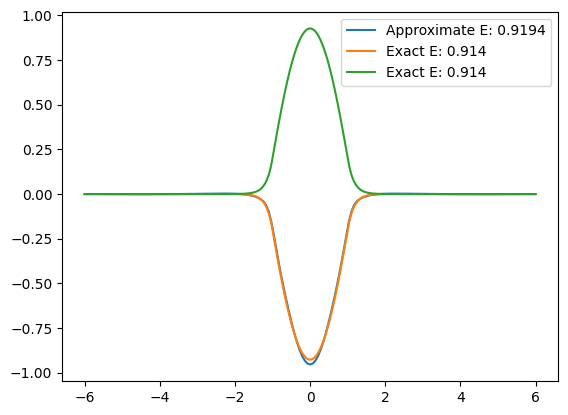

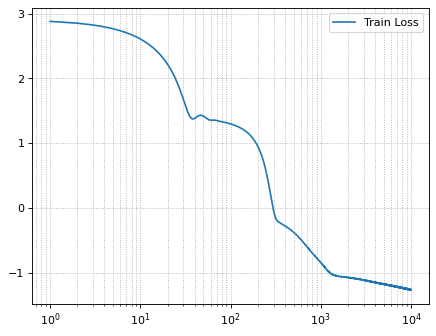

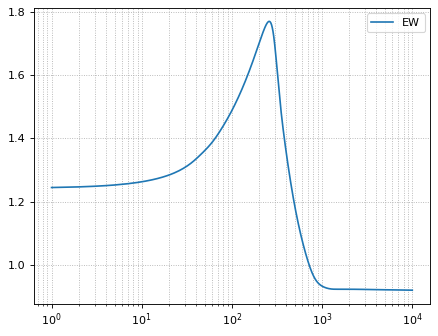

-------  1  -------
Found solution 2 at epoch 14999 with loss -2.223912239074707


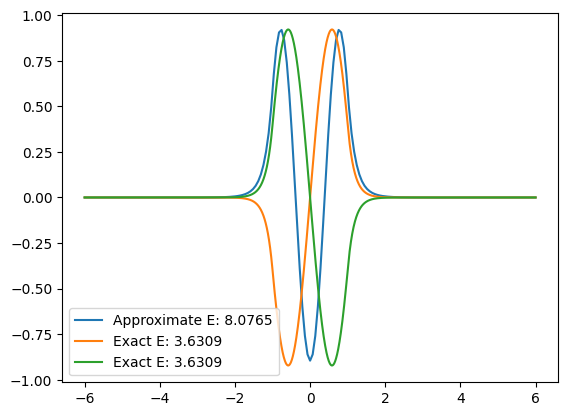

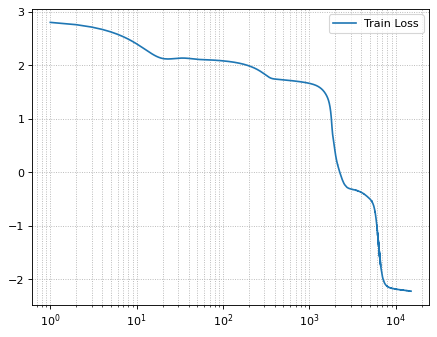

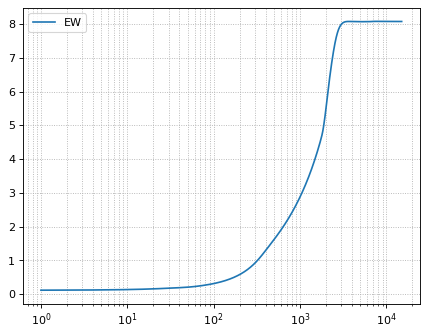

-------  2  -------
Failed passage test with loss  0.9654951095581055


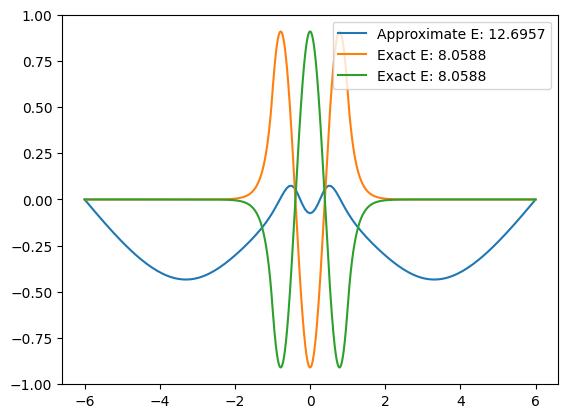

Reinitializing


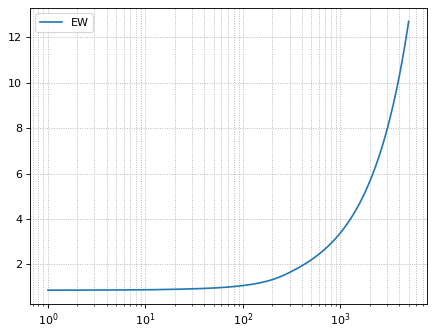

-------  2  -------
Failed passage test with loss  1.0413991212844849


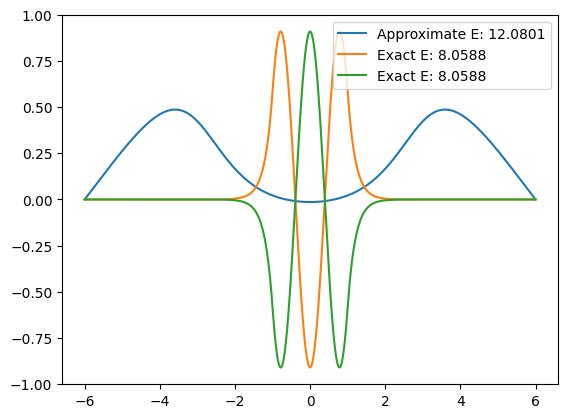

Reinitializing


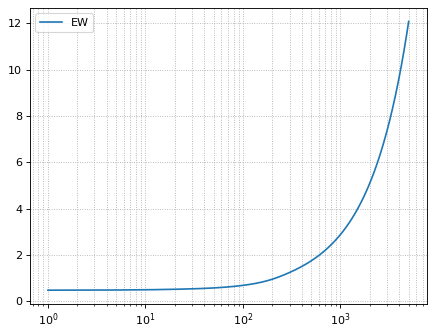

-------  2  -------
Found solution 3 at epoch 19999 with loss -2.788926362991333


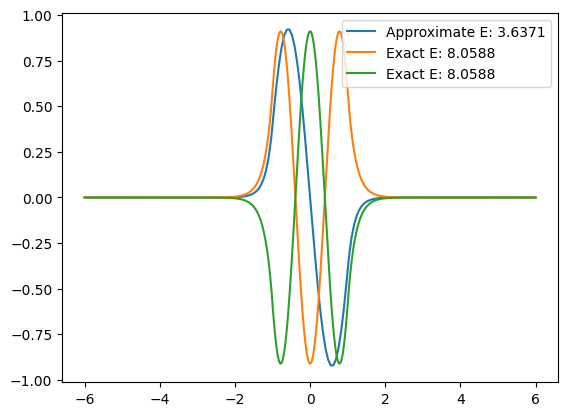

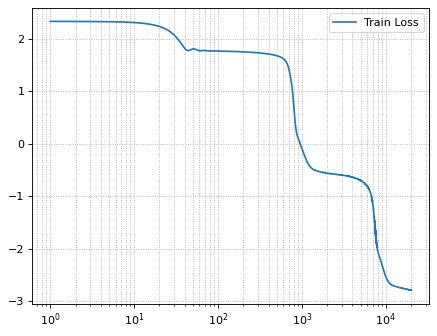

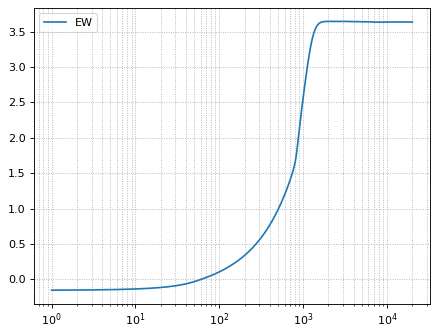

-------  3  -------
Found solution 4 at epoch 19999 with loss -2.0217761993408203


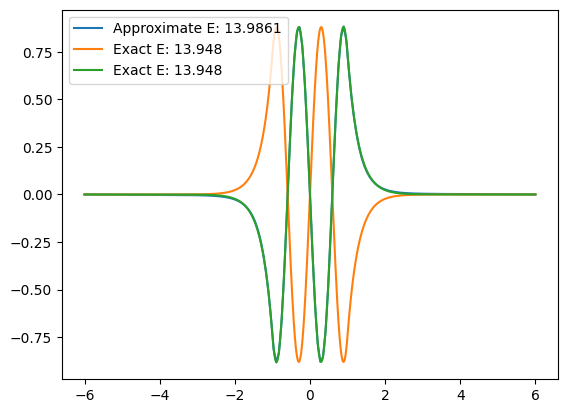

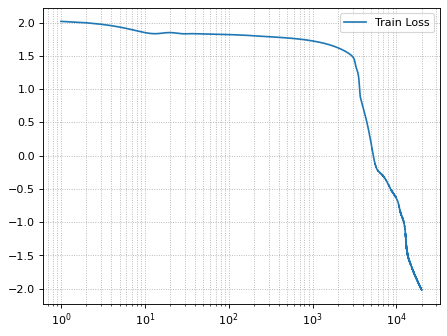

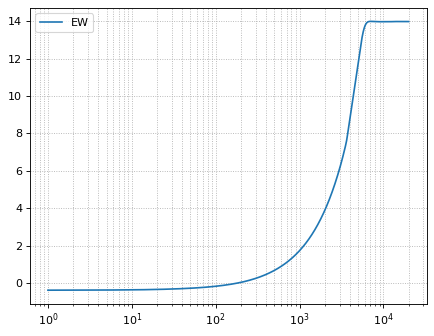

In [3]:
neurons = 5
n_hidden = 2

retrain_seed = 42
batchsize = 10
grid_resol = 175

a = 6
xL = -a; xR = a # shift with 0 into center in order to apply symmetry transformation
sigma = 0.5
pinn = ev_pinn(neurons, n_hidden, xL, xR, grid_resol, batchsize, retrain_seed , sigma)

# Passage test parameters
epoch_test_arr = [5000, 5000, 5000, 7000]
loss_passage_arr = [0, 0, 0, 0.02]

# training epochs
epochs_arr = [10000, 15000, 20000, 20000]

history =pinn.learn_eigenfunction_set(4, epochs_arr, verbose=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

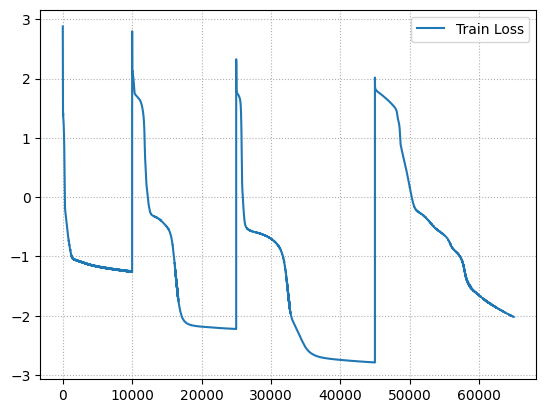

In [34]:
from google.colab import files

plt.figure()
# plt.figure(dpi=80)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(history) + 1), history, label="Train Loss")
plt.legend()
plt.savefig('history_sw.png', bbox_inches ="tight", dpi=300)
files.download("history_sw.png")

In [44]:
# Data analysis section

def compute_errors(NN, n):

    exact_E_list = [0.9139775299185896, 3.6308701258017773, 8.05884816034768, 13.948017271840584, 19.959116238756792]     # from high resolution N=2048 calculation

    # returns relative eigen value and function error
    pts = pinn.add_points()
    _, exact_func_list = pinn.exact_solution(pts.detach().numpy())
    exact_E = exact_E_list[n]
    aprox_func, approx_E = NN(pts)

    exact_func = exact_func_list[n]
    aprox_func, approx_E = aprox_func.squeeze().detach().numpy(), approx_E.detach().numpy()[0]

    # save plots for later
    """approx_E_plot = round(approx_E[0], 4)

    plt.figure()
    plt.plot(pts.detach().numpy(), aprox_func, label= f'Approximate E: {approx_E_plot:.4f}')
    plt.plot(pts.detach().numpy(), exact_func, ls='dashed', label=f'Exact E: {round(exact_E, 4)}')
    plt.plot(pts.detach().numpy(), -exact_func, ls='dashed', label=f'Exact E: {round(exact_E, 4)}')
    plt.legend()
    plt.savefig(f'compare_sols_dashed_{n}.png', bbox_inches ="tight", dpi=300)
    files.download(f'compare_sols_dashed_{n}.png')

    plt.figure()
    plt.plot(pts.detach().numpy(), aprox_func, label= f'Approximate E: {approx_E_plot:.4f}')
    plt.plot(pts.detach().numpy(), exact_func, label=f'Exact E: {round(exact_E, 4)}')
    plt.plot(pts.detach().numpy(), -exact_func, label=f'Exact E: {round(exact_E, 4)}')
    plt.legend()
    plt.savefig(f'compare_sols_{n}.png', bbox_inches ="tight", dpi=300)
    files.download(f'compare_sols_{n}.png')

    plt.figure()
    plt.plot(pts.detach().numpy(), aprox_func, label= f'Approximate E: {approx_E_plot:.4f}')
    plt.legend()
    plt.savefig(f'approx_sol_legend{n}.png', bbox_inches ="tight", dpi=300)
    files.download(f'approx_sol_legend{n}.png')

    plt.figure()
    plt.plot(pts.detach().numpy(), aprox_func)
    plt.savefig(f'approx_sol_{n}.png', bbox_inches ="tight", dpi=300)
    files.download(f'approx_sol_{n}.png')"""

    # calculate errors
    MSE_1 = np.square((exact_func - aprox_func)).mean()
    MSE_2 = np.square((-exact_func - aprox_func)).mean()  #+- coeffcient

    MSE = min(MSE_1, MSE_2) / max(abs(exact_func))  # relative to highest absolute value of exact sol

    error_E = abs((exact_E - approx_E) / exact_E)
    error_MSE = float(MSE)

    error_E_exp = "{:.2e}".format(float(error_E))
    error_MSE_exp = "{:.2e}".format(float(error_MSE))

    return error_E_exp, error_MSE_exp


eigenvals = []

# get list of eigenvalues and sorted list arguments
for NN in pinn.eigenf_list:
    lambda_i = (NN.ev_in( torch.ones(1))).item()
    eigenvals.append(lambda_i)
sort_arg = np.argsort(eigenvals)

print("##### Data analysis #####################")
print("_____ :  E error   : func error")
for n,i in enumerate(sort_arg):
    NN = pinn.eigenf_list[i]
    error_E, error_func = compute_errors(NN, n)
    print( f'n = {n} : ', error_E," : ", error_func)
print("#########################################")

##### Data analysis #####################
_____ :  E error   : func error
n = 0 :  5.93e-03  :  4.89e-05
n = 1 :  1.71e-03  :  1.19e-06
n = 2 :  2.19e-03  :  4.04e-05
n = 3 :  2.73e-03  :  1.07e-05
#########################################
